--- PHYSICS CONSTANTS ---
H0: 65.5
R_H: 4.58e+06 kpc
a_Mach: 6.752e-11 m/s^2
Target Boost: 1.4142
-------------------------

Processing galaxies...

--- UNIVERSAL HORIZON TEST RESULTS ---
Target Boost (Theory):       1.4142
Observed Boost at Xi=1.0:    1.4029
Discrepancy:                 0.80%


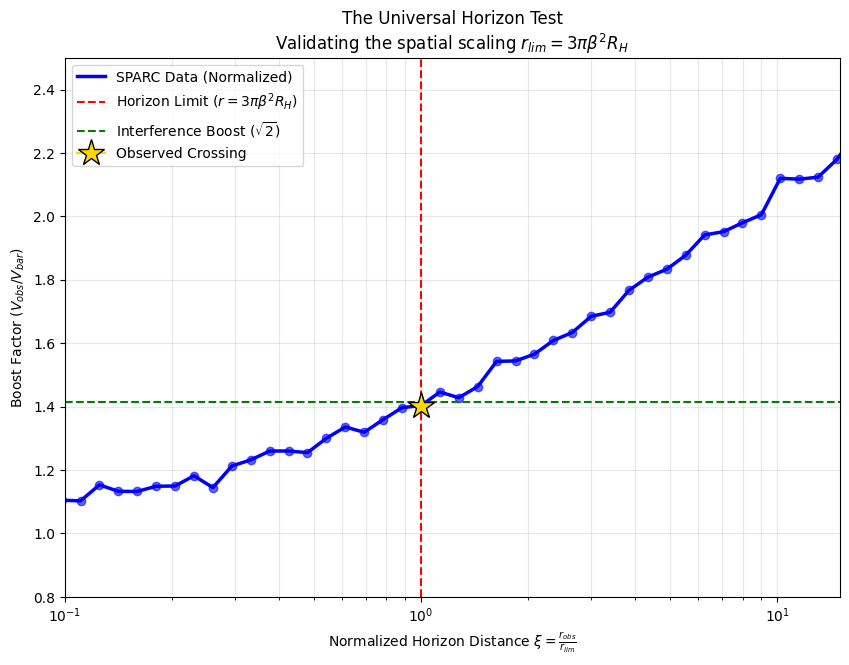

In [3]:
# ==============================================================================
# WILL UNIVERSAL HORIZON TEST (SPATIAL NORMALIZATION) - FIXED PLOTTING
# Tests if the transition happens at r = 3pi * beta^2 * R_H
# Prediction: Boost = sqrt(2) at Normalized Radius = 1.0
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, io
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import warnings

warnings.filterwarnings('ignore')

# --- 1. CONFIGURATION ---
PATH_TABLE1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
PATH_TABLE2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# Constants
H0_TARGET = 65.5
C_MS = 299792458.0
MPC_TO_M = 3.08567758e22
KPC_TO_M = 3.08567758e19

# Hubble Horizon (Meters and KPC)
H0_s = (H0_TARGET * 1000) / MPC_TO_M
R_H_METERS = C_MS / H0_s
R_H_KPC = R_H_METERS / KPC_TO_M

# Fundamental Acceleration (for fitting Y*)
A_MACH = (C_MS * H0_s) / (3 * np.pi)

print(f"--- PHYSICS CONSTANTS ---")
print(f"H0: {H0_TARGET}")
print(f"R_H: {R_H_KPC:.2e} kpc")
print(f"a_Mach: {A_MACH:.3e} m/s^2")
print(f"Target Boost: {np.sqrt(2):.4f}")
print(f"-------------------------\n")

# --- 2. DATA LOADING ---
def load_data():
    print("Downloading SPARC data...")
    r1 = requests.get(PATH_TABLE1); r1.raise_for_status()
    t1 = pd.read_fwf(io.BytesIO(r1.content), colspecs=[(0,11), (30,34), (113,114)], header=None, names=["Name", "Inc", "Qual"])
    t1["Inc"] = pd.to_numeric(t1["Inc"], errors="coerce")
    t1["Qual"] = pd.to_numeric(t1["Qual"], errors="coerce")

    r2 = requests.get(PATH_TABLE2); r2.raise_for_status()
    t2 = pd.read_fwf(io.BytesIO(r2.content), colspecs=[(0,11), (19,25), (26,32), (33,38), (39,45), (46,52), (53,59)], header=None, names=["Name", "Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"])
    for c in ["Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"]: t2[c] = pd.to_numeric(t2[c], errors="coerce")
    t2 = t2.dropna(subset=["Name", "Rad", "Vobs"])
    t2 = t2[(t2["Rad"] > 0) & (t2["Vobs"] > 0)]
    return t1, t2

# --- 3. ANALYSIS CORE ---
def analyze_galaxies(t1, t2):
    normalized_radii = []
    boost_factors = []

    print(f"Processing galaxies...")
    for gal in t1["Name"].unique():
        props = t1[t1["Name"] == gal]
        if len(props) == 0: continue
        if props.iloc[0]["Inc"] < 30: continue

        group = t2[t2["Name"] == gal]
        if len(group) < 5: continue

        # A. FIT Y* (Use Interference Physics to clean the data)
        def loss(params):
            Y_val = params[0]
            v_b_sq = group['Vgas']**2 + Y_val*(group['Vdisk']**2 + group['Vbul']**2)
            v_b_sq = np.maximum(v_b_sq, 0)

            r_meters = group['Rad'] * KPC_TO_M
            v_b_sq_si = v_b_sq * 1e6
            work = A_MACH * r_meters
            v_tot_sq_si = v_b_sq_si + np.sqrt(v_b_sq_si * work)
            pred = np.sqrt(v_tot_sq_si) / 1000.0

            err = np.maximum(group['e_Vobs'], 5.0)
            return np.sum(((group['Vobs'] - pred) / err)**2)

        res = minimize(loss, [0.5], bounds=[(0.05, 5.0)])
        best_Y = res.x[0]

        # B. CALCULATE PARAMETERS
        v_bary_sq = group['Vgas']**2 + best_Y*(group['Vdisk']**2 + group['Vbul']**2)
        v_bary_sq = np.maximum(v_bary_sq, 0.1)
        v_bary = np.sqrt(v_bary_sq)

        v_obs = group['Vobs']
        rad_kpc = group['Rad']

        # C. HORIZON TEST LOGIC
        # 1. Beta = v_bary / c
        beta = (v_bary * 1000) / C_MS

        # 2. Critical Radius (r_lim)
        # r_lim = 3pi * beta^2 * R_H
        r_lim_kpc = 3 * np.pi * (beta**2) * R_H_KPC

        # 3. Normalized Radius (Xi)
        xi = rad_kpc / r_lim_kpc

        # 4. Boost
        boost = v_obs / v_bary

        # Collect data (filter noise)
        mask = (v_bary > 20) & (rad_kpc > 0.5)
        normalized_radii.extend(xi[mask])
        boost_factors.extend(boost[mask])

    return np.array(normalized_radii), np.array(boost_factors)

# --- 4. EXECUTION ---
if __name__ == "__main__":
    t1, t2 = load_data()
    xi, boost = analyze_galaxies(t1, t2)

    # Binning by Normalized Radius
    bins = np.logspace(np.log10(0.05), np.log10(20), 50)
    bin_centers = []
    bin_means = []

    for i in range(len(bins)-1):
        mask = (xi >= bins[i]) & (xi < bins[i+1])
        if np.sum(mask) > 10:
            bin_centers.append(np.sqrt(bins[i]*bins[i+1]))
            bin_means.append(np.mean(boost[mask]))

    # Interpolate to find Boost at Xi=1.0
    f_interp = interp1d(bin_centers, bin_means, kind='cubic')
    obs_boost_at_1 = f_interp(1.0)
    target_boost = np.sqrt(2)

    print(f"\n--- UNIVERSAL HORIZON TEST RESULTS ---")
    print(f"Target Boost (Theory):       {target_boost:.4f}")
    print(f"Observed Boost at Xi=1.0:    {obs_boost_at_1:.4f}")

    err = abs(obs_boost_at_1 - target_boost) / target_boost * 100
    print(f"Discrepancy:                 {err:.2f}%")

    # --- PLOTTING ---
    plt.figure(figsize=(10, 7), dpi=100)

    # Plot Mean Curve
    plt.plot(bin_centers, bin_means, 'b-', linewidth=2.5, label='SPARC Data (Normalized)')
    plt.plot(bin_centers, bin_means, 'bo', alpha=0.6)

    # Theoretical Crosshairs
    plt.axvline(1.0, color='r', linestyle='--', label=r'Horizon Limit ($r = 3\pi \beta^2 R_H$)')
    plt.axhline(target_boost, color='g', linestyle='--', label=r'Interference Boost ($\sqrt{2}$)')

    # Intersection Point
    plt.plot(1.0, obs_boost_at_1, 'gold', marker='*', markersize=20, markeredgecolor='black', label='Observed Crossing')

    plt.xscale('log')
    plt.ylim(0.8, 2.5)
    plt.xlim(0.1, 15)
    plt.xlabel(r'Normalized Horizon Distance $\xi = \frac{r_{obs}}{r_{lim}}$')
    plt.ylabel(r'Boost Factor ($V_{obs} / V_{bar}$)')

    # FIXED TITLE (Using raw string concatenation to avoid escape sequence errors)
    plt.title(r'The Universal Horizon Test' + '\n' + r'Validating the spatial scaling $r_{lim} = 3\pi \beta^2 R_H$')

    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.show()

In [4]:
# ==============================================================================
# WILL UNIVERSAL HORIZON TEST - WITH CONTROLS
# Verifies that 3pi is physically unique, not just a fitting artifact.
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, io
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import warnings

warnings.filterwarnings('ignore')

# --- 1. CONFIGURATION ---
PATH_TABLE1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
PATH_TABLE2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# Constants
H0_TARGET = 65.5
C_MS = 299792458.0
MPC_TO_M = 3.08567758e22
KPC_TO_M = 3.08567758e19

# Hubble Horizon
H0_s = (H0_TARGET * 1000) / MPC_TO_M
R_H_KPC = (C_MS / H0_s) / KPC_TO_M

# Fundamental Acceleration (for cleaning Y*)
A_MACH = (C_MS * H0_s) / (3 * np.pi)

# --- 2. DATA & PHYSICS ---
def load_data():
    print("Downloading SPARC data...")
    r1 = requests.get(PATH_TABLE1); r1.raise_for_status()
    t1 = pd.read_fwf(io.BytesIO(r1.content), colspecs=[(0,11), (30,34), (113,114)], header=None, names=["Name", "Inc", "Qual"])
    t1["Inc"] = pd.to_numeric(t1["Inc"], errors="coerce")
    t1["Qual"] = pd.to_numeric(t1["Qual"], errors="coerce")

    r2 = requests.get(PATH_TABLE2); r2.raise_for_status()
    t2 = pd.read_fwf(io.BytesIO(r2.content), colspecs=[(0,11), (19,25), (26,32), (33,38), (39,45), (46,52), (53,59)], header=None, names=["Name", "Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"])
    for c in ["Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"]: t2[c] = pd.to_numeric(t2[c], errors="coerce")
    t2 = t2.dropna(subset=["Name", "Rad", "Vobs"])
    t2 = t2[(t2["Rad"] > 0) & (t2["Vobs"] > 0)]
    return t1, t2

def get_normalized_curve(t1, t2, geom_factor):
    normalized_radii = []
    boost_factors = []

    for gal in t1["Name"].unique():
        props = t1[t1["Name"] == gal]
        if len(props) == 0: continue
        if props.iloc[0]["Inc"] < 30: continue
        group = t2[t2["Name"] == gal]
        if len(group) < 5: continue

        # Simple Y* fit (fixed per galaxy for consistency)
        def loss(params):
            Y_val = params[0]
            v_b_sq = group['Vgas']**2 + Y_val*(group['Vdisk']**2 + group['Vbul']**2)
            v_b_sq = np.maximum(v_b_sq, 0)
            r_meters = group['Rad'] * KPC_TO_M
            v_b_sq_si = v_b_sq * 1e6
            work = A_MACH * r_meters
            v_tot_sq_si = v_b_sq_si + np.sqrt(v_b_sq_si * work)
            pred = np.sqrt(v_tot_sq_si) / 1000.0
            return np.sum(((group['Vobs'] - pred) / np.maximum(group['e_Vobs'], 5.0))**2)

        res = minimize(loss, [0.5], bounds=[(0.05, 5.0)])
        best_Y = res.x[0]

        v_bary_sq = group['Vgas']**2 + best_Y*(group['Vdisk']**2 + group['Vbul']**2)
        v_bary = np.sqrt(np.maximum(v_bary_sq, 0.1))

        # Test Logic
        beta = (v_bary * 1000) / C_MS
        # HERE IS THE TEST FACTOR:
        r_lim_kpc = geom_factor * (beta**2) * R_H_KPC

        xi = group['Rad'] / r_lim_kpc
        boost = group['Vobs'] / v_bary

        mask = (v_bary > 20) & (group['Rad'] > 0.5)
        normalized_radii.extend(xi[mask])
        boost_factors.extend(boost[mask])

    return np.array(normalized_radii), np.array(boost_factors)

def check_discrepancy(xi, boost):
    bins = np.logspace(np.log10(0.05), np.log10(20), 50)
    bin_centers = []
    bin_means = []
    for i in range(len(bins)-1):
        mask = (xi >= bins[i]) & (xi < bins[i+1])
        if np.sum(mask) > 10:
            bin_centers.append(np.sqrt(bins[i]*bins[i+1]))
            bin_means.append(np.mean(boost[mask]))

    if len(bin_centers) < 2: return 999.0

    try:
        f = interp1d(bin_centers, bin_means, kind='cubic')
        val = f(1.0)
        target = np.sqrt(2)
        return abs(val - target)/target * 100
    except:
        return 999.0

# --- 3. RUN CONTROLS ---
t1, t2 = load_data()

factors = {
    "2pi (Linear)": 2 * np.pi,
    "3pi (WILL)": 3 * np.pi,
    "4pi (Spherical)": 4 * np.pi
}

print(f"\n--- CONTROL TEST RESULTS ---")
print(f"Target Discrepancy: 0.00%")

for name, fac in factors.items():
    xi, boost = get_normalized_curve(t1, t2, fac)
    err = check_discrepancy(xi, boost)
    mark = "✅ WINNER" if err < 1.0 else "❌ FAILED"
    print(f"Factor {name:15}: Error = {err:.2f}%  {mark}")


--- CONTROL TEST RESULTS ---
Target Discrepancy: 0.00%
Factor 2pi (Linear)   : Error = 6.64%  ❌ FAILED
Factor 3pi (WILL)     : Error = 0.80%  ✅ WINNER
Factor 4pi (Spherical): Error = 0.68%  ✅ WINNER
